In [ ]:
# Install catalax
# !pip install catalax

In [2]:
import warnings

import catalax as ctx
import catalax.mcmc as cmc

warnings.filterwarnings("ignore")

# Hamiltonian Monte Carlo (HMC) Parameter Estimation

This notebook demonstrates how to use Catalax for Bayesian parameter estimation using Hamiltonian Monte Carlo (HMC) sampling. We'll work with a simple Michaelis-Menten enzyme kinetics model and estimate the parameters `v_max` and `K_m` from noisy experimental data.

## Overview
1. Define a simple enzyme kinetics model with Michaelis-Menten kinetics
2. Load and augment experimental data with realistic noise
3. Set up Bayesian priors for the parameters
4. Perform HMC sampling to estimate parameter distributions
5. Analyze and visualize the results


In [ ]:
# Initialize the model
model = ctx.Model(name="Simple menten model")

# Add species
model.add_state("s1")

# Add ODEs
model.add_ode("s1", "- (v_max * s1) / ( K_m + s1)")

# Prepare the model for bayes and define priors
model.parameters["v_max"].value = 7.0
model.parameters["K_m"].value = 100.0

# Save the model
model.save("./models/", "menten_model")

model

,name,symbol
0,s1,s1


,name,symbol,value,constant,initial_value,equation,lower_bound,upper_bound,hdi
0,K_m,K_m,100.0,False,None,None,None,None,None
1,v_max,v_max,7.0,False,None,None,None,None,None


""


""



Model(
    name='Simple menten model',
    odes=DottedDict({'s1': ODE(equation=-s1*v_max/(K_m + s1), parameters=DottedDict({'v_max': Parameter(name='v_max', symbol=v_max, value=7.0, constant=False, identifiability=None, initial_value=None, equation=None, lower_bound=None, upper_bound=None, hdi=None, prior=None), 'K_m': Parameter(name='K_m', symbol=K_m, value=100.0, constant=False, identifiability=None, initial_value=None, equation=None, lower_bound=None, upper_bound=None, hdi=None, prior=None)}), species=Species(name='s1', symbol=s1), observable=True)}),
    species=,
    parameters=,
    constants=,
    assignments=
)

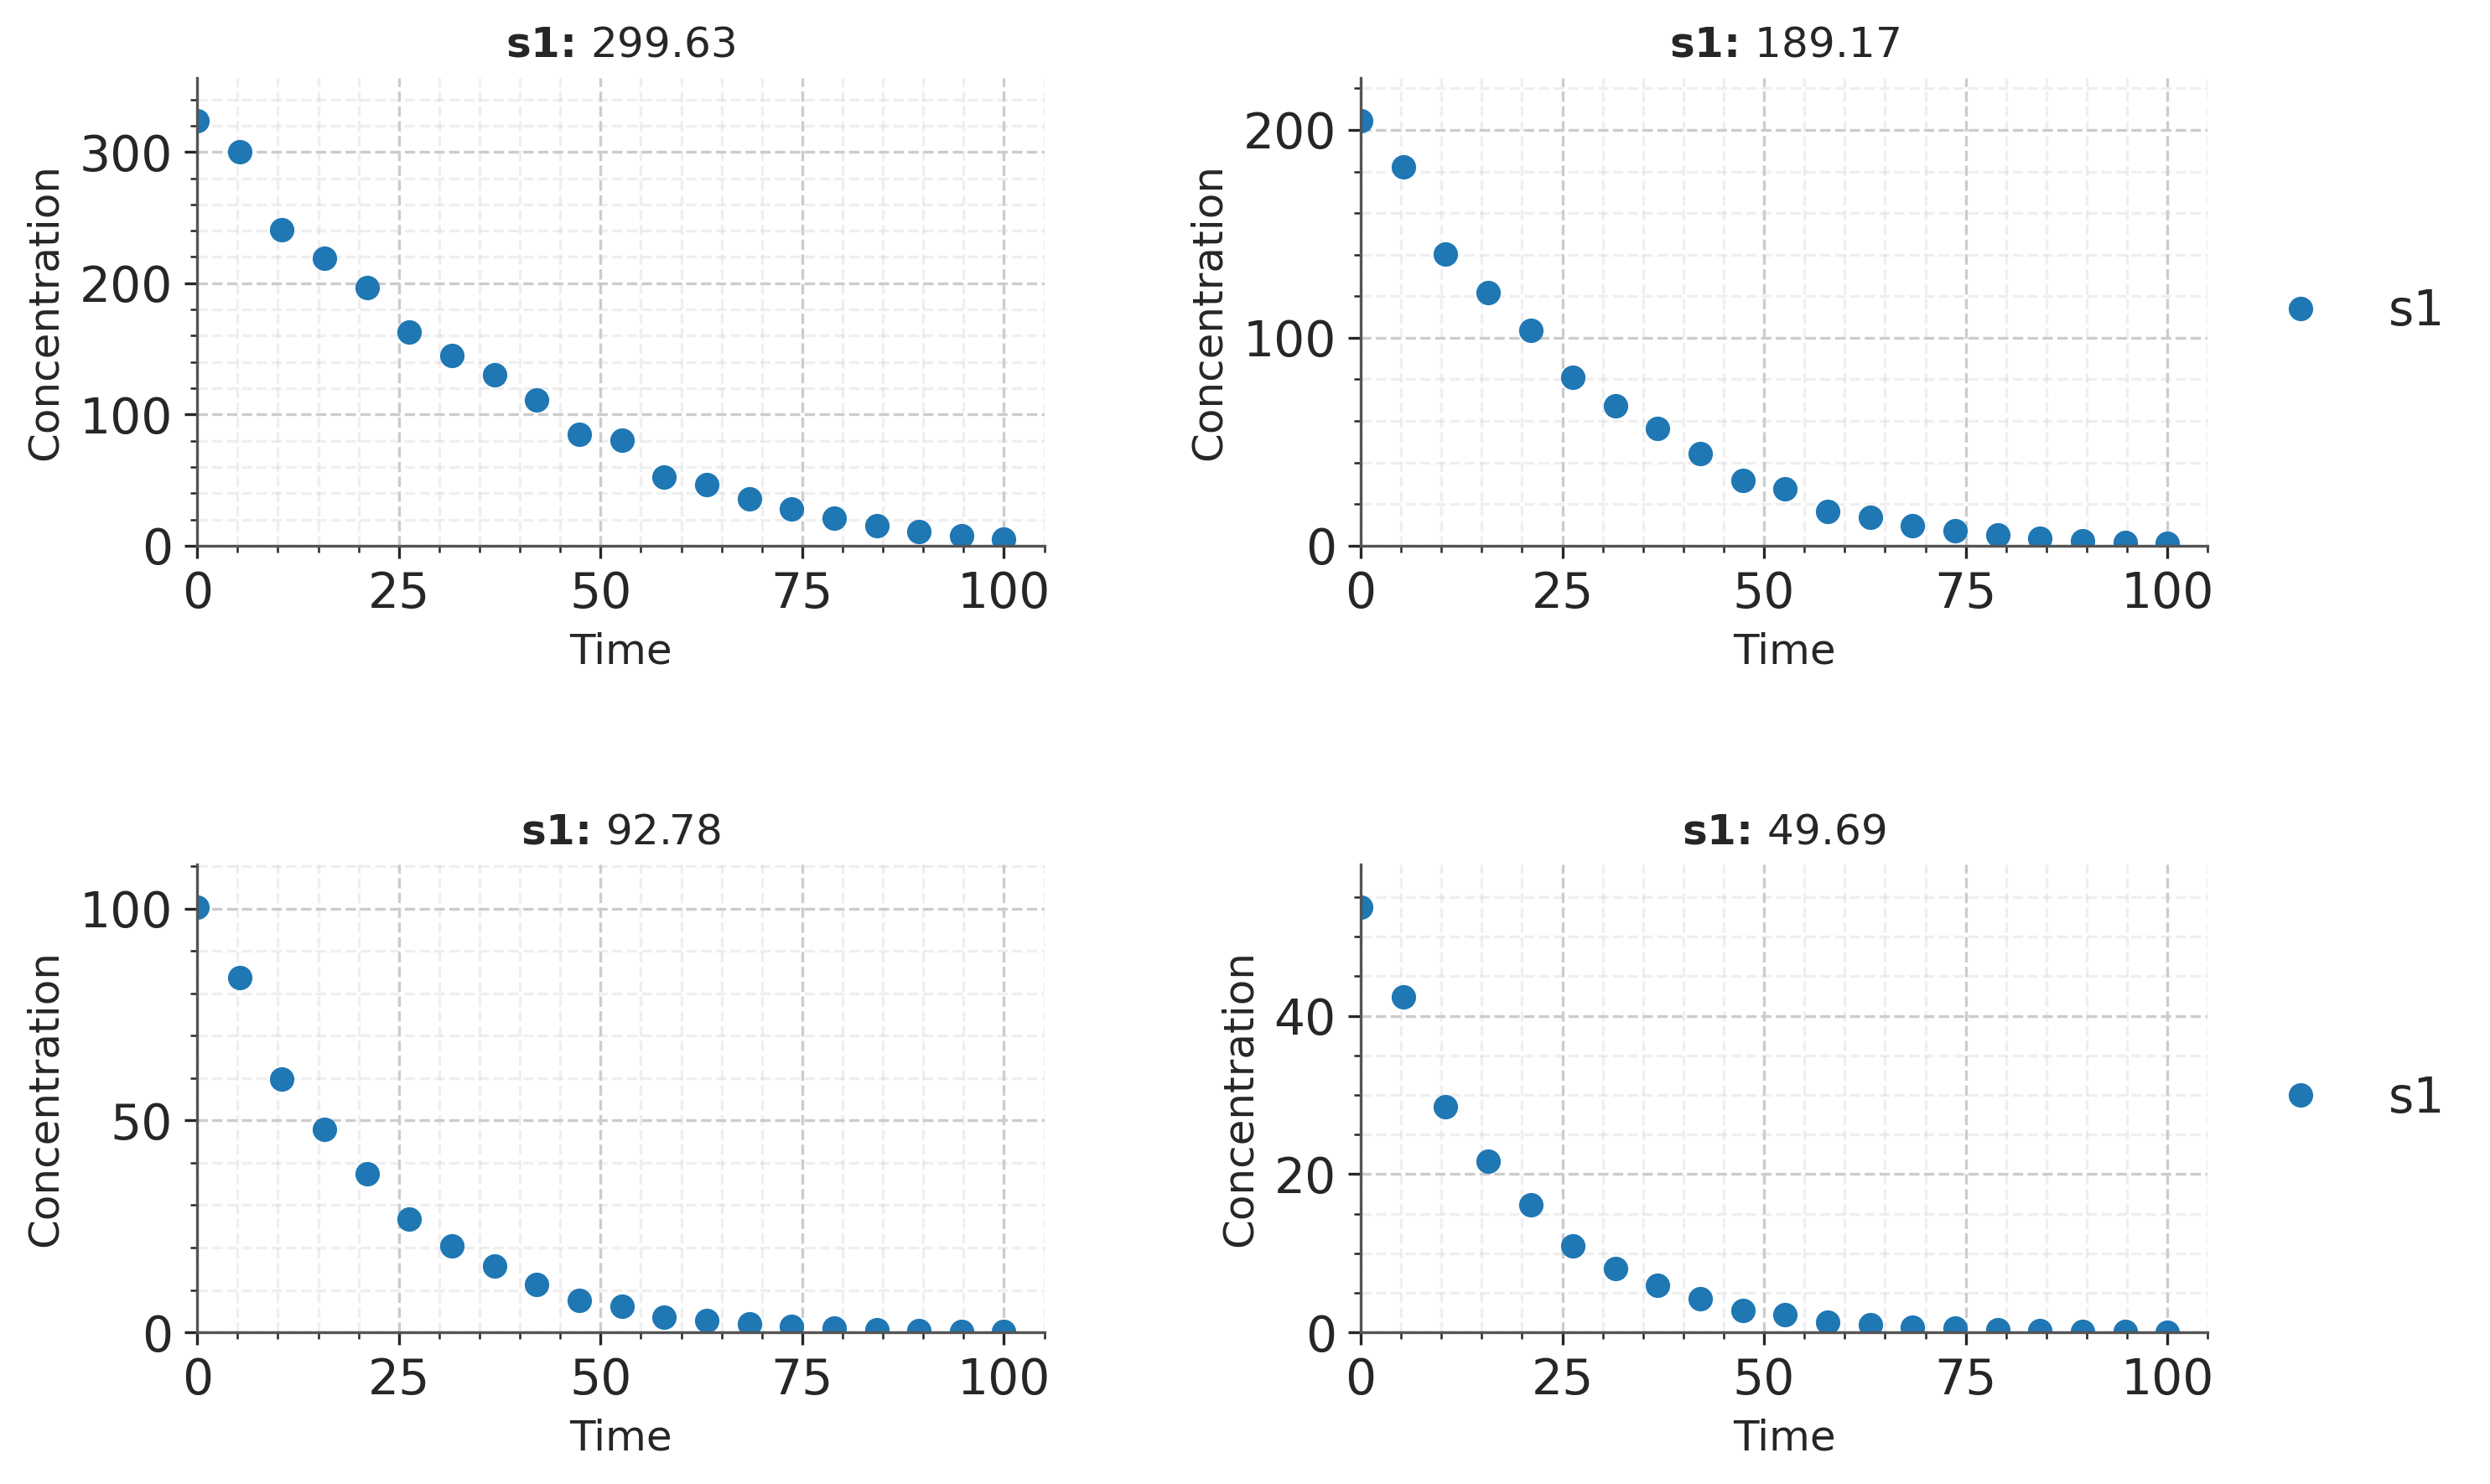

In [4]:
# Load the datasets
dataset = ctx.Dataset.from_croissant("datasets/croissant_dataset.zip")

# We need to add some noise to the data to make it more realistic
dataset = dataset.augment(
    n_augmentations=1,
    seed=0,
    sigma=5e-2,
    append=False,
    multiplicative=True,
)

dataset.plot(
    measurement_ids=[m.id for m in dataset.measurements[:4]],
    show=True,
)

In [5]:
# Define Priors
model.parameters["v_max"].prior = cmc.priors.Uniform(low=1e-6, high=200.0)
model.parameters["K_m"].prior = cmc.priors.Uniform(low=1e-6, high=1e3)

# Save the model and its priors
model.save("./models/", "menten_model_w_priors")

In [6]:
# Perform MCMC simulation
hmc = cmc.HMC(
    num_warmup=1000,
    num_samples=1000,
    dt0=0.1,
    max_steps=64**4,
    verbose=1,
)

results = hmc.run(model=model, dataset=dataset, yerrs=2.0)

# Apply the median posterior to the model
fitted_model = results.get_fitted_model()

# Print the summary
results.summary()


🚀 Running MCMC



sample: 100%|██████████| 2000/2000 [02:14<00:00, 14.85it/s, 11 steps of size 2.83e-01. acc. prob=0.94]
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
K_m,102.868,1.043,100.822,104.944,0.048,0.034,480.0,399.0,NaN
sigma,2.138,0.041,2.069,2.220,0.002,0.001,578.0,530.0,NaN
v_max,7.087,0.035,7.018,7.154,0.002,0.001,486.0,360.0,NaN


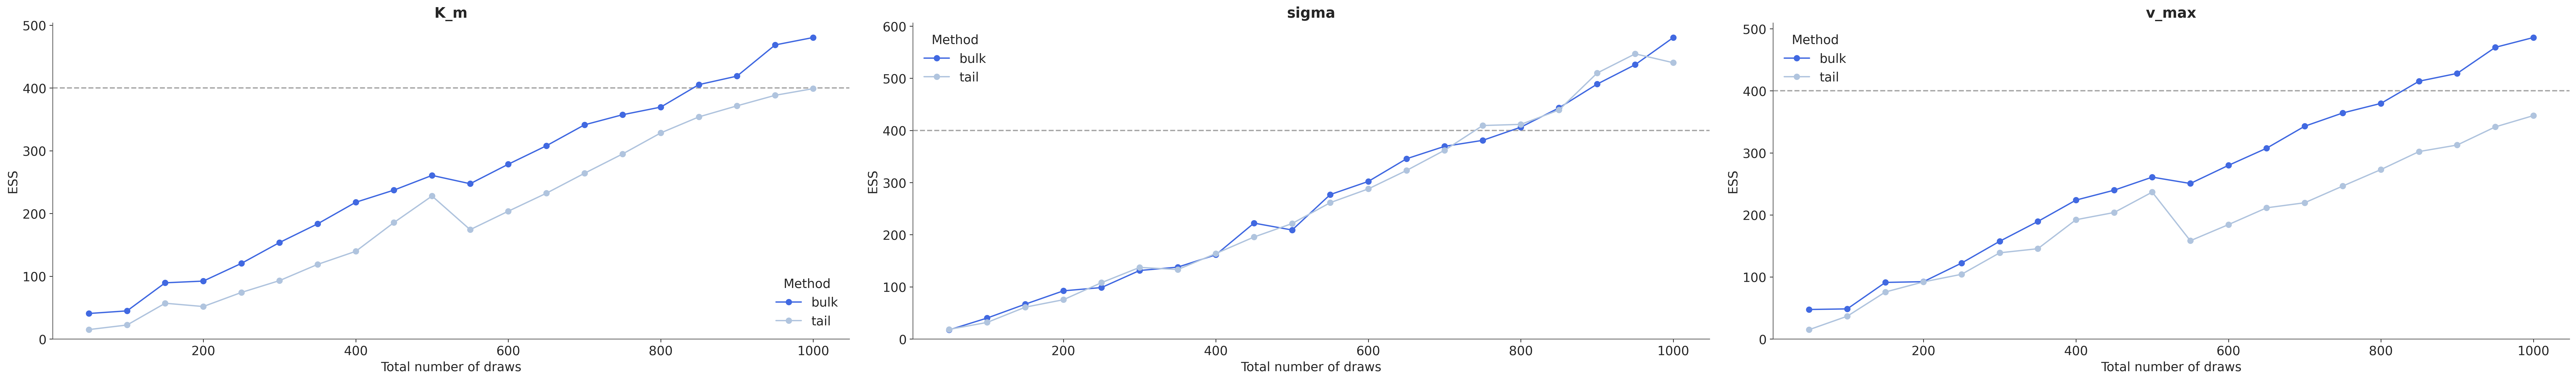

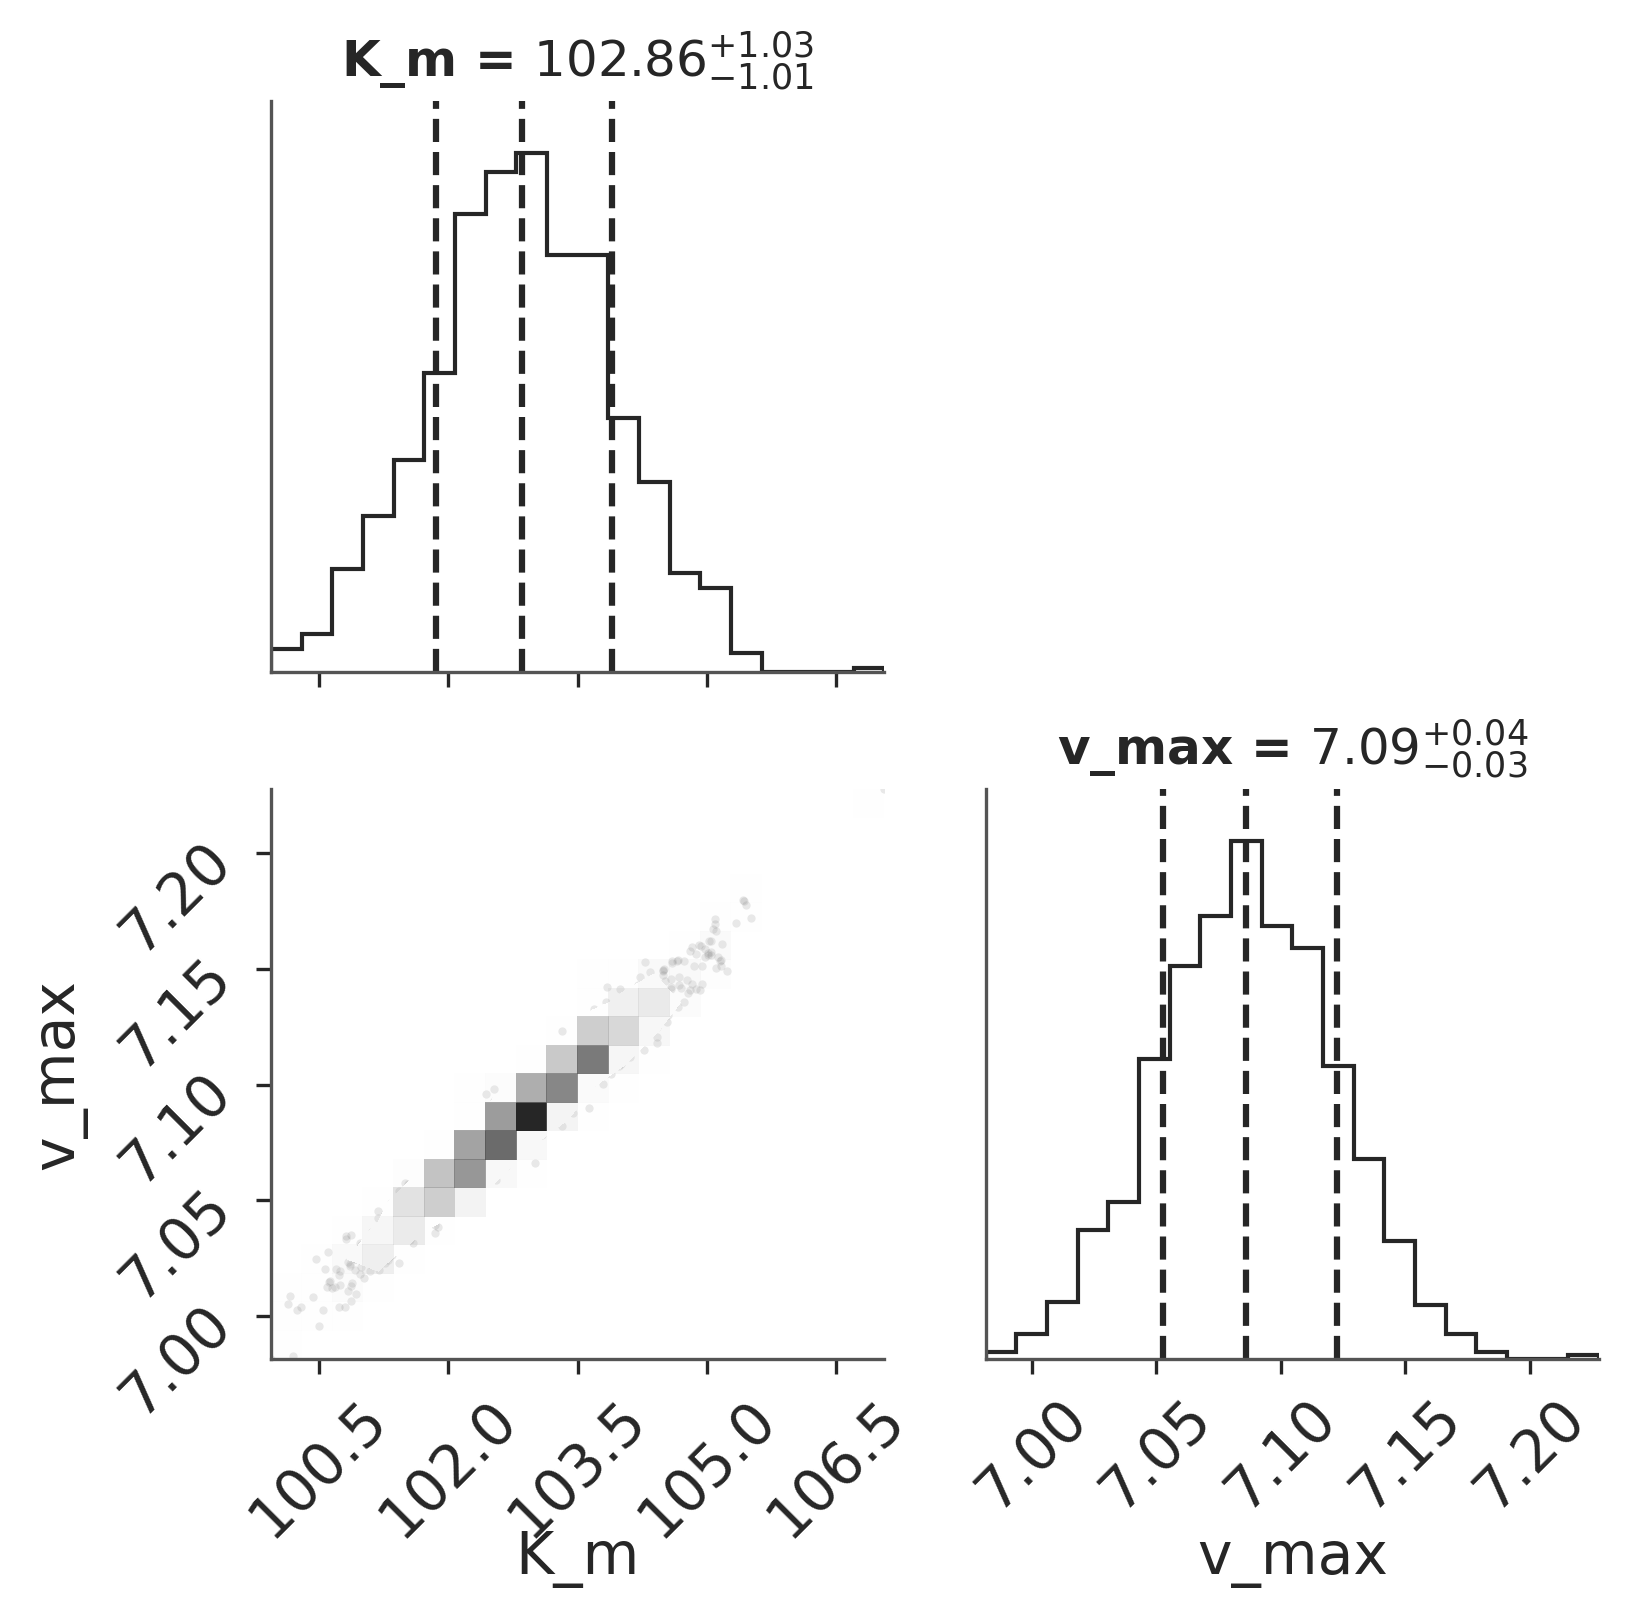

In [7]:
# Plot the trace
results.plot_ess(show=True)

# Plot the corner
results.plot_corner(show=True)

has hdi


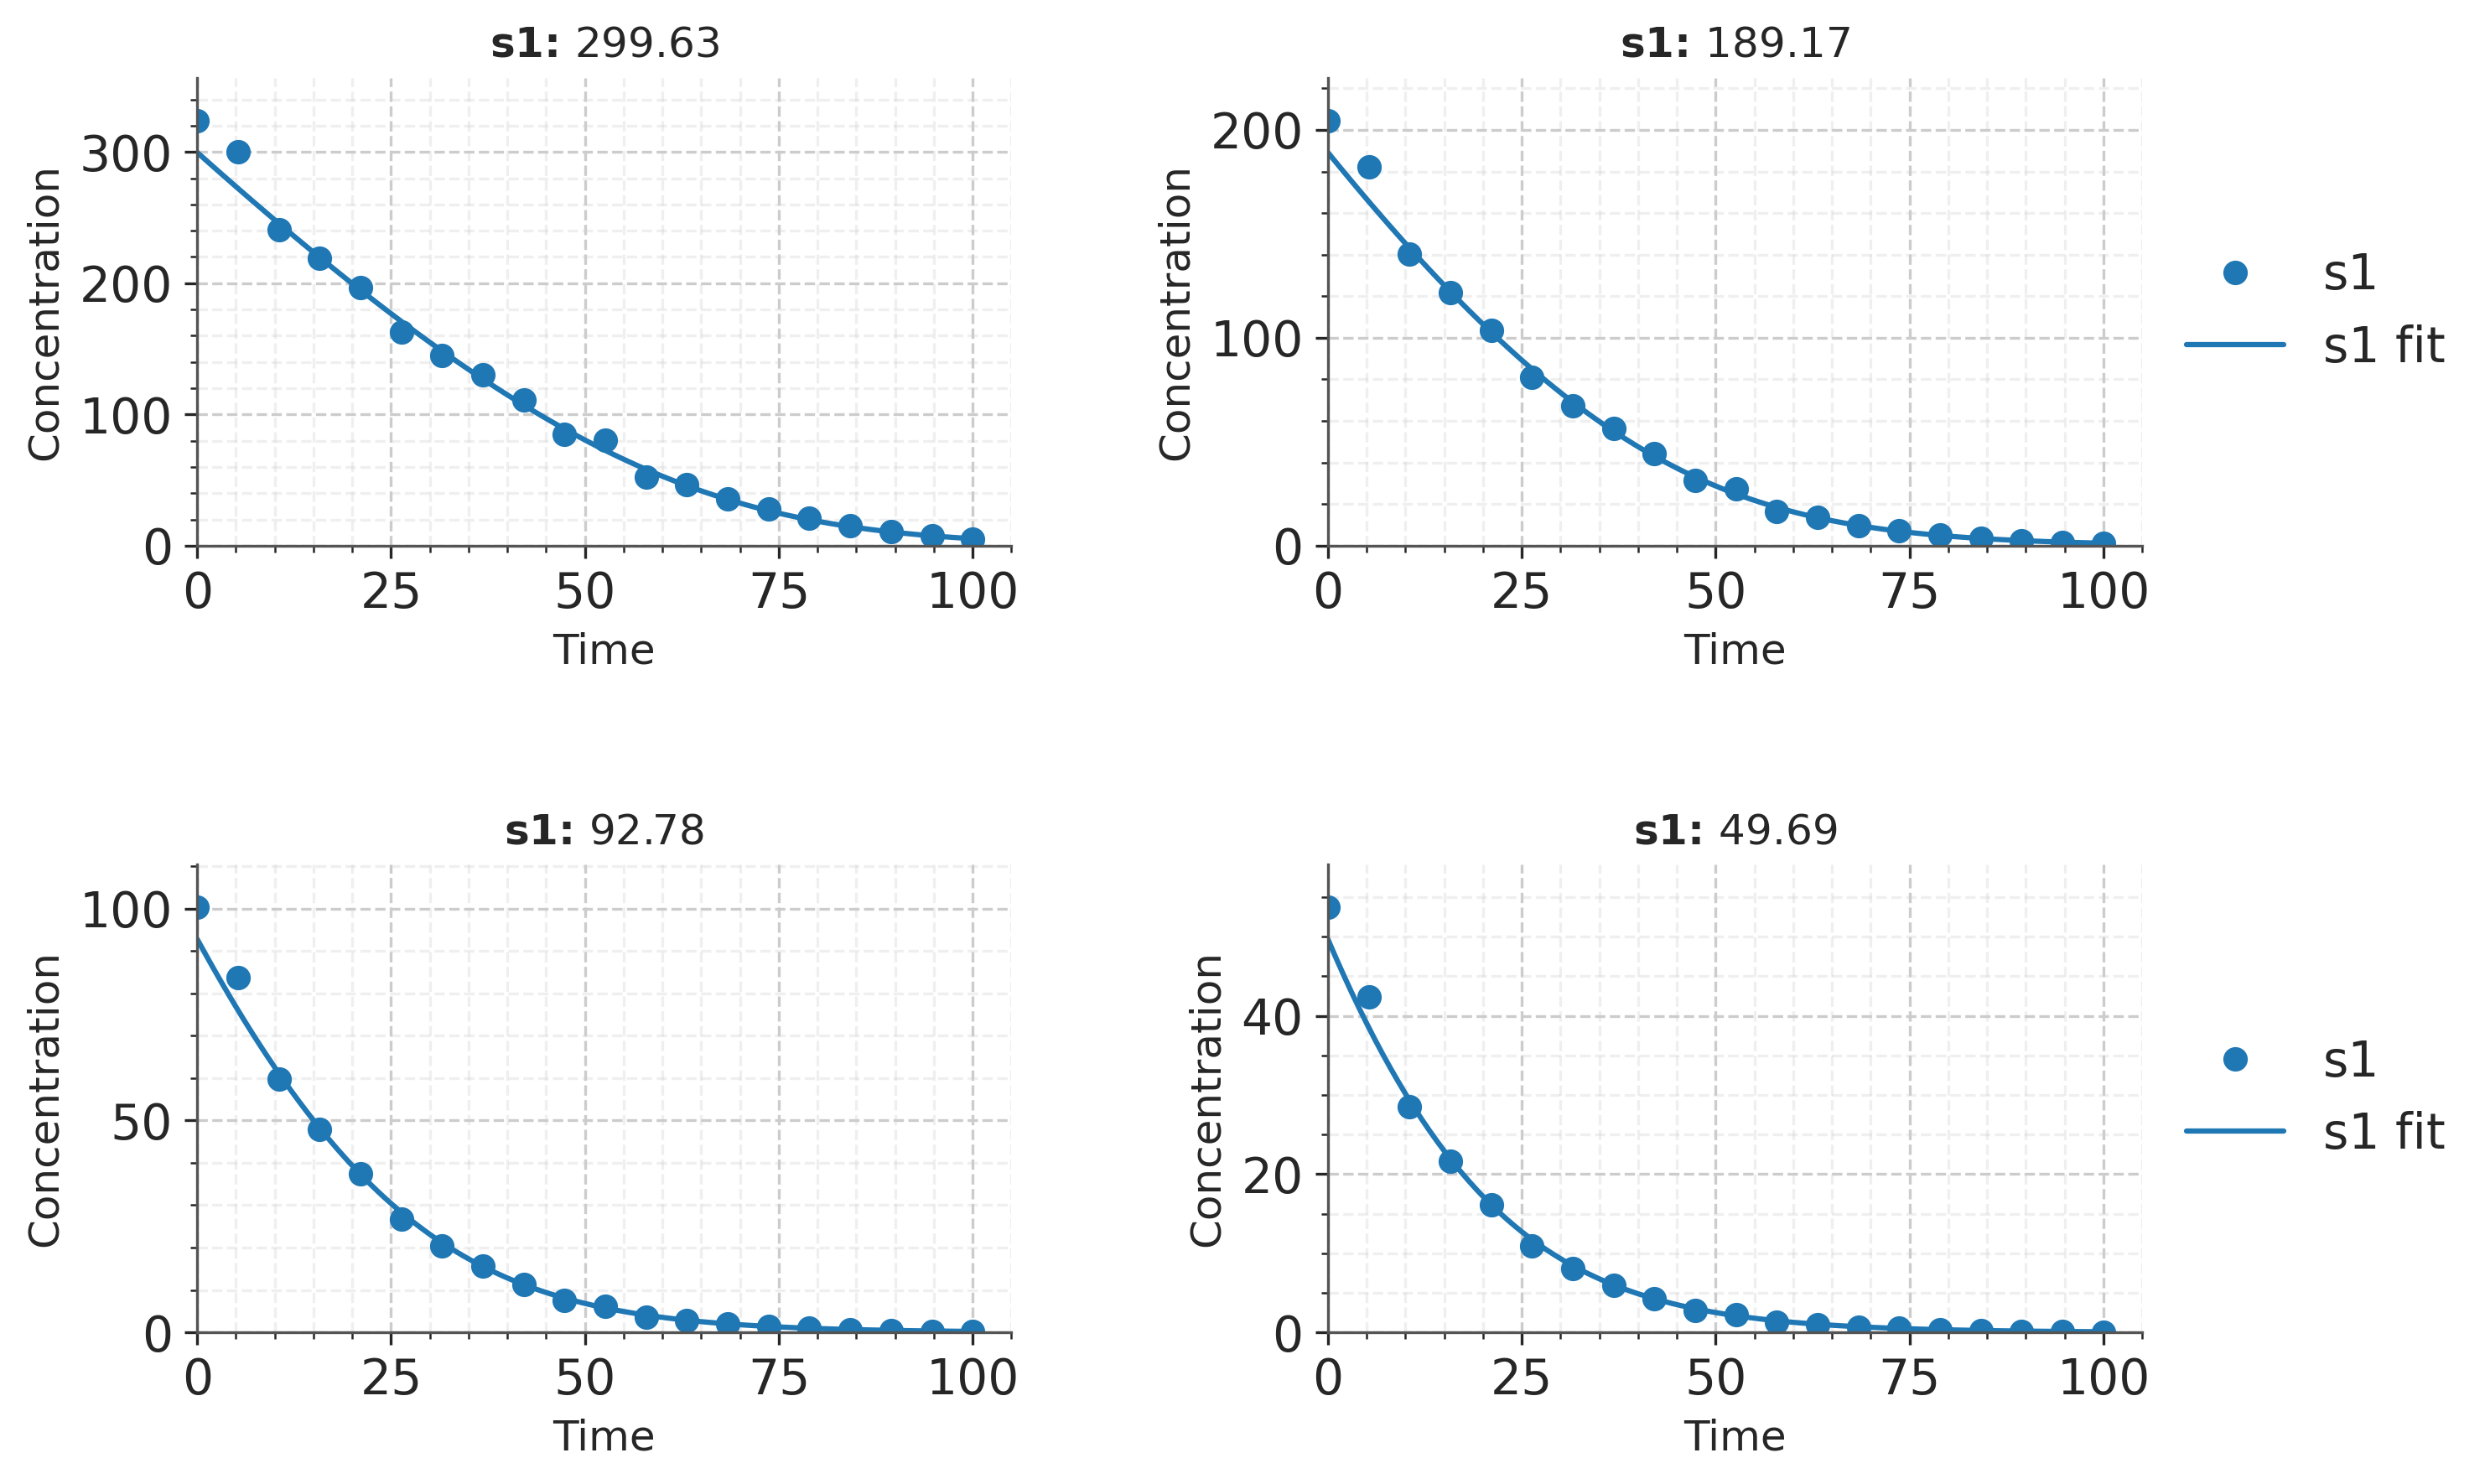

In [8]:
dataset.plot(
    predictor=fitted_model,
    measurement_ids=[m.id for m in dataset.measurements[:4]],
    show=True,
)